# Estonian Pension Fund Fee Analysis (2022–2026)

You can run this analysis on your own computer by downloading the [source notebook from GitHub](https://github.com/TulevaEE/reporting-engine/blob/main/reports/adhoc/fee_analysis.ipynb).

Asset-weighted analysis of II and III pillar pension fund fees using public data from pensionikeskus.ee.

**Data sources:**
- OCF (Ongoing Charges Figure) — scraped from pensionikeskus.ee fee comparison tables
- AUM (Assets Under Management) — downloaded daily net asset values, averaged annually
- Management fee (valitsemistasu) — scraped from pensionikeskus.ee fund fees comparison table

**Date of the report:** 2026-02-26 (change if you want fresh data)

**Note on 2026 data:** AUM figures for 2026 cover January–February only. Fee estimates for 2026 are based on this partial-year average and may differ from the full-year result.

In [1]:
import sys, io, re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from bs4 import BeautifulSoup
from pathlib import Path

project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root / 'common' / 'scripts'))
from generate_charts import setup_plot_style, TULEVA_BLUE, TULEVA_NAVY, TULEVA_MID_BLUE

setup_plot_style()

# Report date — change this to fetch fresh AUM data
REPORT_DATE = '2026-02-26'

# Provider color palette
PROVIDER_COLORS = {
    'Tuleva': TULEVA_NAVY,
    'LHV': '#FF4800',
    'Swedbank': '#F7A600',
    'SEB': '#51c26c',
    'Luminor': '#8B5CF6',
}
PROVIDER_ORDER = ['Tuleva', 'LHV', 'Swedbank', 'SEB', 'Luminor']
LATEST_YEAR = 2026

# Fund IDs on pensionikeskus.ee (for AUM downloads)
II_FUND_IDS = [36,37,38,39,47,48,49,50,51,52,57,58,59,60,61,73,74,75,76,77,80,86,88,91]
III_FUND_IDS = [32,33,34,41,42,43,53,55,72,79,81,84,85,87,89,90,93]

# III pillar: Estonian OCF page name → English AUM name
III_NAME_MAP = {
    'LHV Pensionifond Aktiivne III': 'LHV Pensionifond Aktiivne III',
    'LHV Pensionifond Indeks III': 'LHV Pensionifond Indeks III',
    'Luminor Jätkusuutlik Tulevik 50-55 Indeks Pensionifond': 'Luminor Sustainable Future 50-55 Index Pension fund',
    'Luminor Tulevik 16-50 Pensionifond': 'Luminor Tulevik 16-50 Pension Fund',
    'Luminor Tulevik 55+ Pensionifond': 'Luminor Tulevik 55+ Pension Fund',
    'Luminor Tulevik Indeks Pensionifond': 'Luminor Future Index pension fund',
    'SEB III samba pensionifond 18+': 'SEB III Pillar Pension Fund 18+',
    'SEB III samba pensionifond 65+': 'SEB III Pillar Pension Fund 65+',
    'SEB kliimatuleviku pensionifond indeks': 'SEB Climate Future Pension Fund Index',
    'Swedbank III Samba Pensionifond Indeks': 'Swedbank III Pillar Pension Fund Index',
    'Swedbank Pensionifond V100': 'Swedbank Pension Fund V100',
    'Swedbank Pensionifond V100 indeks': 'Swedbank Pension Fund V100 index (limited redemption)',
    'Swedbank Pensionifond V100 indeks (väljumine piiratud)': 'Swedbank Pension Fund V100 index (limited redemption)',
    'Swedbank Pensionifond V30': 'Swedbank Pension Fund V30',
    'Swedbank Pensionifond V30 indeks': 'Swedbank Pension Fund V30 index (limited redemption)',
    'Swedbank Pensionifond V30 indeks (väljumine piiratud)': 'Swedbank Pension Fund V30 index (limited redemption)',
    'Swedbank Pensionifond V60': 'Swedbank Pension Fund V60',
    'Swedbank Pensionifond V60 indeks': 'Swedbank Pension Fund V60 index (limited redemption)',
    'Swedbank Pensionifond V60 indeks (väljumine piiratud)': 'Swedbank Pension Fund V60 index (limited redemption)',
    'Tuleva III Samba Pensionifond': 'Tuleva III Pillar Pension Fund',
}


def weighted_avg(ter, aum):
    """Asset-weighted average OCF."""
    mask = ter.notna() & aum.notna() & (aum > 0)
    if mask.sum() == 0:
        return np.nan
    return (ter[mask] * aum[mask]).sum() / aum[mask].sum()


def parse_provider(name):
    for p in ['LHV', 'Luminor', 'SEB', 'Swedbank', 'Tuleva']:
        if p.lower() in name.lower():
            return p
    return 'Other'


def parse_strategy(name):
    # All Tuleva funds are passive index funds (name doesn't contain "indeks")
    if re.search(r'tuleva', name, re.IGNORECASE):
        return 'index'
    return 'index' if re.search(r'indeks|index', name, re.IGNORECASE) else 'active'


def fetch_aum(pillar_path, fund_ids, date_from='2022-01-01', date_to=REPORT_DATE):
    """Download daily AUM data from pensionikeskus.ee and compute annual averages."""
    params = '&'.join([f'f[{i}]={fid}' for i, fid in enumerate(fund_ids)])
    url = (f'https://www.pensionikeskus.ee/en/statistics/{pillar_path}'
           f'?download=xls&date_from={date_from}&date_to={date_to}&{params}')
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    raw = pd.read_csv(io.BytesIO(resp.content), sep='\t', encoding='utf-16')
    raw['Fund'] = raw['Fund'].str.strip()
    raw = raw[~raw['Fund'].str.contains('Total|Kokku', case=False, na=False)]
    raw['Date'] = pd.to_datetime(raw['Date'])
    raw['Net assets'] = pd.to_numeric(
        raw['Net assets'].astype(str).str.replace(',', '').str.replace(' ', ''),
        errors='coerce')
    raw['year'] = raw['Date'].dt.year
    aum = raw.groupby(['Fund', 'year'])['Net assets'].mean().reset_index()
    aum.columns = ['fund', 'year', 'avg_aum']
    return aum, raw


print('Setup complete')

Setup complete


In [2]:
# Fetch II pillar OCF
url = 'https://www.pensionikeskus.ee/en/ii-pillar/funds-fees/funds-total-expense-ratio-comparison/'
resp = requests.get(url, timeout=30)
resp.raise_for_status()

soup = BeautifulSoup(resp.text, 'html.parser')
table = soup.find('table')
rows = table.find_all('tr')

headers = [th.get_text(strip=True) for th in rows[0].find_all(['th', 'td'])]
data = []
for row in rows[1:]:
    cells = [td.get_text(strip=True) for td in row.find_all(['td', 'th'])]
    if cells and cells[0]:
        data.append(cells)

df_ii_ter = pd.DataFrame(data, columns=headers)
df_ii_ter = df_ii_ter.rename(columns={headers[0]: 'fund'})
df_ii_ter['fund'] = df_ii_ter['fund'].str.strip()

year_cols_ii = [c for c in df_ii_ter.columns if c.isdigit()]
for col in year_cols_ii:
    df_ii_ter[col] = (df_ii_ter[col].str.replace('%', '').str.replace(',', '.')
                      .str.replace('–', '').str.replace('—', '').str.strip())
    df_ii_ter[col] = pd.to_numeric(df_ii_ter[col], errors='coerce')

print(f'II pillar OCF: {len(df_ii_ter)} funds, year columns {year_cols_ii}')

# Display with dual header rows for year context
display_df = df_ii_ter.set_index('fund')
in_effect = pd.DataFrame([{c: int(c)+1 for c in display_df.columns}],
                         index=['Fees in effect →'])
audited = pd.DataFrame([{c: int(c) for c in display_df.columns}],
                       index=['Based on audited results of →'])
display_df = pd.concat([in_effect, audited, display_df])
display_df.columns = range(len(display_df.columns))  # hide header row
display_df.index.name = None

(display_df.style
 .format('{:.2f}', subset=pd.IndexSlice[display_df.index[2:], :])
 .format('{:.0f}', subset=pd.IndexSlice[display_df.index[:2], :])
 .set_properties(subset=pd.IndexSlice[display_df.index[:1], :],
                 **{'font-weight': 'bold', 'text-align': 'right'})
 .set_properties(subset=pd.IndexSlice[display_df.index[1:2], :],
                 **{'font-style': 'italic', 'color': '#666', 'text-align': 'right'})
 .set_properties(subset=pd.IndexSlice[display_df.index[2:], :],
                 **{'text-align': 'right'})
 .hide(axis='columns')
)

II pillar OCF: 24 funds, year columns ['2021', '2022', '2023', '2024', '2025']


Fees in effect →,2022,2023,2024,2025,2026
Based on audited results of →,2021,2022,2023,2024,2025
LHV Pensionifond Ettevõtlik,1.62,1.95,1.56,1.48,1.57
LHV Pensionifond Indeks,0.33,0.32,0.32,0.30,0.27
LHV Pensionifond Julge,1.28,1.73,1.22,1.21,1.21
LHV Pensionifond Rahulik,0.53,0.55,0.57,0.54,0.53
LHV Pensionifond Tasakaalukas,1.17,1.25,1.09,1.14,1.13
Luminor 16-50 pension fund,1.44,1.30,1.18,1.13,1.08
Luminor 50-56 pension fund,1.43,1.33,1.23,1.17,1.13
Luminor 56+ pension fund,1.35,1.27,1.19,1.17,1.14
Luminor 61-65 pension fund,1.01,0.95,0.87,0.86,0.88


In [3]:
# Fetch III pillar OCF (Estonian page → map names to English)
url = 'https://www.pensionikeskus.ee/iii-sammas/vabatahtlikud-fondid/jooksvate-tasude-vordlus/'
resp = requests.get(url, timeout=30)
resp.raise_for_status()

soup = BeautifulSoup(resp.text, 'html.parser')
table = soup.find('table')
rows = table.find_all('tr')

headers = [th.get_text(strip=True) for th in rows[0].find_all(['th', 'td'])]
data = []
for row in rows[1:]:
    cells = [td.get_text(strip=True) for td in row.find_all(['td', 'th'])]
    if cells and cells[0]:
        data.append(cells)

df_iii_ter = pd.DataFrame(data, columns=headers)
df_iii_ter = df_iii_ter.rename(columns={headers[0]: 'fund'})
df_iii_ter['fund'] = df_iii_ter['fund'].str.strip()

year_cols_iii = [c for c in df_iii_ter.columns if c.isdigit()]
for col in year_cols_iii:
    df_iii_ter[col] = (df_iii_ter[col].str.replace('%', '').str.replace(',', '.')
                       .str.replace('–', '').str.replace('—', '').str.strip())
    df_iii_ter[col] = pd.to_numeric(df_iii_ter[col], errors='coerce')

# Map Estonian names to English
df_iii_ter['fund'] = df_iii_ter['fund'].map(III_NAME_MAP).fillna(df_iii_ter['fund'])
unmapped = df_iii_ter[~df_iii_ter['fund'].isin(III_NAME_MAP.values())]
if len(unmapped):
    print(f'WARNING: {len(unmapped)} unmapped III pillar funds: {unmapped["fund"].tolist()}')

print(f'III pillar OCF: {len(df_iii_ter)} funds, year columns {year_cols_iii}')

# Display with dual header rows for year context
display_df = df_iii_ter.set_index('fund')
in_effect = pd.DataFrame([{c: int(c)+1 for c in display_df.columns}],
                         index=['Fees in effect →'])
audited = pd.DataFrame([{c: int(c) for c in display_df.columns}],
                       index=['Based on audited results of →'])
display_df = pd.concat([in_effect, audited, display_df])
display_df.columns = range(len(display_df.columns))  # hide header row
display_df.index.name = None

(display_df.style
 .format('{:.2f}', subset=pd.IndexSlice[display_df.index[2:], :])
 .format('{:.0f}', subset=pd.IndexSlice[display_df.index[:2], :])
 .set_properties(subset=pd.IndexSlice[display_df.index[:1], :],
                 **{'font-weight': 'bold', 'text-align': 'right'})
 .set_properties(subset=pd.IndexSlice[display_df.index[1:2], :],
                 **{'font-style': 'italic', 'color': '#666', 'text-align': 'right'})
 .set_properties(subset=pd.IndexSlice[display_df.index[2:], :],
                 **{'text-align': 'right'})
 .hide(axis='columns')
)

III pillar OCF: 17 funds, year columns ['2021', '2022', '2023', '2024', '2025']


Fees in effect →,2022,2023,2024,2025,2026
Based on audited results of →,2021,2022,2023,2024,2025
LHV Pensionifond Aktiivne III,1.46,1.44,1.19,1.21,1.21
LHV Pensionifond Indeks III,0.42,0.40,0.37,0.36,0.32
Luminor Sustainable Future 50-55 Index Pension fund,0.58,0.58,0.54,0.57,0.55
Luminor Tulevik 16-50 Pension Fund,2.14,1.93,1.77,1.18,1.16
Luminor Tulevik 55+ Pension Fund,1.77,1.76,1.66,1.24,1.18
Luminor Future Index pension fund,nan,nan,nan,nan,0.38
SEB III Pillar Pension Fund 18+,1.19,1.19,1.18,1.16,1.27
SEB III Pillar Pension Fund 65+,1.13,1.10,1.09,1.05,1.05
SEB Climate Future Pension Fund Index,nan,0.42,0.41,0.41,0.39


In [4]:
# Fetch II and III pillar AUM (daily net assets → annual averages)
df_ii_aum, df_ii_aum_raw = fetch_aum('ii-pillar/value-of-assets-of-funded-pension/', II_FUND_IDS)
df_iii_aum, df_iii_aum_raw = fetch_aum(
    'iii-pillar/value-of-assets-of-suppl-funded-pension/', III_FUND_IDS)

print(f'II pillar: {len(df_ii_aum_raw):,} raw rows, III pillar: {len(df_iii_aum_raw):,} raw rows')

# Combined summary table
ii_summary = df_ii_aum.groupby('year').agg(
    funds_ii=('fund', 'nunique'), aum_ii=('avg_aum', 'sum')).rename_axis('Year')
iii_summary = df_iii_aum.groupby('year').agg(
    funds_iii=('fund', 'nunique'), aum_iii=('avg_aum', 'sum')).rename_axis('Year')
summary = ii_summary.join(iii_summary)
summary['aum_total'] = summary['aum_ii'] + summary['aum_iii']
summary = summary[['funds_ii', 'funds_iii', 'aum_ii', 'aum_iii', 'aum_total']]
summary.columns = ['Funds (II)', 'Funds (III)', 'Avg AUM II (EUR bn)',
                    'Avg AUM III (EUR bn)', 'Avg AUM Total (EUR bn)']

(summary.style
 .format('{:.0f}', subset=['Funds (II)', 'Funds (III)'])
 .format(lambda x: f'{x/1e9:.2f}', subset=[c for c in summary.columns if 'EUR' in c])
)

II pillar: 24,985 raw rows, III pillar: 16,832 raw rows


,Funds (II),Funds (III),Avg AUM II (EUR bn),Avg AUM III (EUR bn),Avg AUM Total (EUR bn)
Year,,,,,
2021,23,15,4.26,0.38,4.64
2022,23,16,3.95,0.39,4.33
2023,24,16,4.36,0.50,4.86
2024,24,16,5.38,0.73,6.11
2025,24,17,6.15,0.96,7.10
2026,24,17,6.92,1.16,8.08


In [5]:
# Build combined dataset: OCF + AUM + metadata

def melt_ter(df_ter, year_cols, pillar):
    """Melt wide OCF table to long format with year shift."""
    long = df_ter.melt(id_vars='fund', value_vars=year_cols,
                       var_name='ter_year', value_name='ter')
    long['ter_year'] = long['ter_year'].astype(int)
    long['year'] = long['ter_year'] + 1  # OCF year N → analysis year N+1
    long['pillar'] = pillar
    return long[(long['year'] >= 2022) & (long['year'] <= 2026)]

ter_ii = melt_ter(df_ii_ter, year_cols_ii, 'II')
ter_iii = melt_ter(df_iii_ter, year_cols_iii, 'III')
ter_long = pd.concat([ter_ii, ter_iii], ignore_index=True)

# SEB fallback: no 2025 OCF → use 2024 OCF for analysis year 2026
seb_2026 = (ter_long['fund'].str.contains('SEB', case=False)
            & (ter_long['year'] == 2026)
            & ter_long['ter'].isna())
for idx in ter_long[seb_2026].index:
    fund = ter_long.loc[idx, 'fund']
    prev = ter_long[(ter_long['fund'] == fund) & (ter_long['year'] == 2025)]['ter']
    if not prev.empty and prev.notna().any():
        ter_long.loc[idx, 'ter'] = prev.values[0]
n_seb_filled = seb_2026.sum()
print(f'SEB fallback: filled {n_seb_filled} funds with 2024 OCF for 2026')

# Combine AUM
aum_all = pd.concat([
    df_ii_aum.assign(pillar='II'),
    df_iii_aum.assign(pillar='III'),
], ignore_index=True)

# Join OCF + AUM
df = ter_long.merge(aum_all, on=['fund', 'year', 'pillar'], how='inner')
df = df[df['ter'].notna()].copy()

# Metadata
df['provider'] = df['fund'].apply(parse_provider)
df['strategy'] = df['fund'].apply(parse_strategy)
df['fee_eur'] = df['ter'] / 100 * df['avg_aum']

# Diagnostics
ter_funds = set(ter_long['fund'].unique())
aum_funds = set(aum_all['fund'].unique())
ter_only = ter_funds - aum_funds
aum_only = aum_funds - ter_funds
if ter_only:
    print(f'OCF-only (no AUM match): {ter_only}')
if aum_only:
    print(f'AUM-only (no OCF match): {aum_only}')

print(f'\nCombined dataset: {len(df)} rows, {df["fund"].nunique()} funds')
print(f'Pillars: {df["pillar"].value_counts().to_dict()}')
print(f'Providers: {df["provider"].value_counts().to_dict()}')
print(f'Strategy: {df["strategy"].value_counts().to_dict()}')

# Summary table
summary = df.groupby(['pillar', 'year']).agg(
    funds=('fund', 'nunique'),
    total_aum_M=('avg_aum', lambda x: x.sum() / 1e6),
).reset_index()
summary['wavg_ocf'] = df.groupby(['pillar', 'year']).apply(
    lambda g: weighted_avg(g['ter'], g['avg_aum'])).values
summary.style.format({'total_aum_M': '{:,.0f}', 'wavg_ocf': '{:.3f}%'})

SEB fallback: filled 0 funds with 2024 OCF for 2026

Combined dataset: 199 rows, 41 funds
Pillars: {'II': 119, 'III': 80}
Providers: {'Swedbank': 69, 'Luminor': 41, 'SEB': 39, 'LHV': 35, 'Tuleva': 15}
Strategy: {'active': 124, 'index': 75}


,pillar,year,funds,total_aum_M,wavg_ocf
0,II,2022,23,"3,948",0.964%
1,II,2023,24,"4,360",1.037%
2,II,2024,24,"5,380",0.865%
3,II,2025,24,"6,150",0.783%
4,II,2026,24,"6,922",0.775%
5,III,2022,15,385,0.923%
6,III,2023,16,496,0.827%
7,III,2024,16,729,0.728%
8,III,2025,16,955,0.660%
9,III,2026,17,"1,159",0.634%


## Overview

*Lower fees are proven way to improve investors' long-term returns. How much do Estonian pension fund investors pay in fees, what has improved and what still needs improvement?*

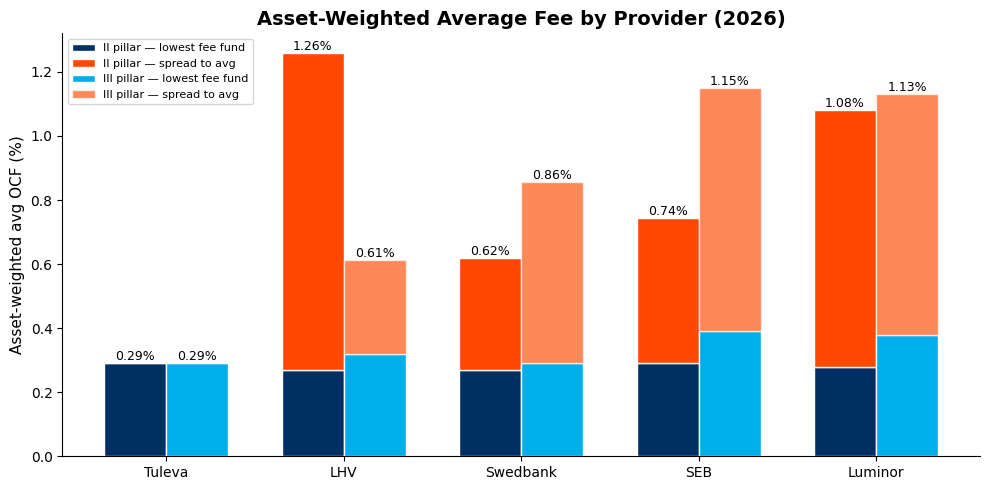

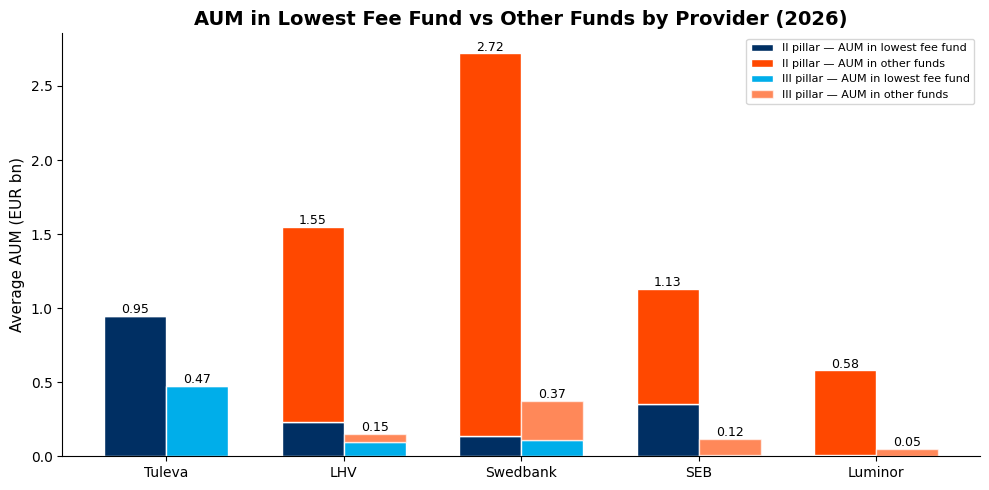

In [6]:
# Asset-weighted average fee by provider (current year)
latest = df[df['year'] == LATEST_YEAR]

wavg_data = []
for provider in PROVIDER_ORDER:
    for pillar in ['II', 'III']:
        sub = latest[(latest['provider'] == provider) & (latest['pillar'] == pillar)]
        if len(sub):
            min_ter = sub['ter'].min()
            low_aum = sub.loc[sub['ter'] == min_ter, 'avg_aum'].sum()
            rest_aum = sub.loc[sub['ter'] != min_ter, 'avg_aum'].sum()
            wavg_data.append({
                'provider': provider, 'pillar': pillar,
                'wavg_ter': weighted_avg(sub['ter'], sub['avg_aum']),
                'min_ter': min_ter,
                'total_aum': sub['avg_aum'].sum(),
                'low_aum': low_aum,
                'rest_aum': rest_aum,
                'funds': sub['fund'].nunique(),
            })
wavg_df = pd.DataFrame(wavg_data)
wavg_pivot = wavg_df.pivot(index='provider', columns='pillar', values='wavg_ter').reindex(PROVIDER_ORDER)
min_pivot = wavg_df.pivot(index='provider', columns='pillar', values='min_ter').reindex(PROVIDER_ORDER)
spread_pivot = wavg_pivot - min_pivot
low_aum_pivot = wavg_df.pivot(index='provider', columns='pillar', values='low_aum').reindex(PROVIDER_ORDER) / 1e9
rest_aum_pivot = wavg_df.pivot(index='provider', columns='pillar', values='rest_aum').reindex(PROVIDER_ORDER) / 1e9

# --- Chart 1: Fee breakdown (lowest fee + spread) ---
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(wavg_pivot))
w = 0.35

ax.bar(x - w/2, min_pivot['II'], w, color=TULEVA_NAVY, edgecolor='white', label='II pillar — lowest fee fund')
ax.bar(x - w/2, spread_pivot['II'], w, bottom=min_pivot['II'],
       color='#FF4800', edgecolor='white', label='II pillar — spread to avg')
ax.bar(x + w/2, min_pivot['III'], w, color=TULEVA_BLUE, edgecolor='white', label='III pillar — lowest fee fund')
ax.bar(x + w/2, spread_pivot['III'], w, bottom=min_pivot['III'],
       color='#FF4800', edgecolor='white', alpha=0.65, label='III pillar — spread to avg')

ax.set_ylim(0)
ax.set_xticks(x)
ax.set_xticklabels(wavg_pivot.index)
ax.set_ylabel('Asset-weighted avg OCF (%)')
ax.set_title(f'Asset-Weighted Average Fee by Provider ({LATEST_YEAR})', fontweight='bold')
ax.legend(fontsize=8)

for i, provider in enumerate(PROVIDER_ORDER):
    for pillar, offset in [('II', -w/2), ('III', w/2)]:
        avg = wavg_pivot.loc[provider, pillar]
        if not np.isnan(avg):
            ax.text(i + offset, avg + 0.01, f'{avg:.2f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# --- Chart 2: AUM breakdown (lowest fee fund vs rest) ---
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x - w/2, low_aum_pivot['II'], w, color=TULEVA_NAVY, edgecolor='white',
       label='II pillar — AUM in lowest fee fund')
ax.bar(x - w/2, rest_aum_pivot['II'], w, bottom=low_aum_pivot['II'],
       color='#FF4800', edgecolor='white', label='II pillar — AUM in other funds')
ax.bar(x + w/2, low_aum_pivot['III'], w, color=TULEVA_BLUE, edgecolor='white',
       label='III pillar — AUM in lowest fee fund')
ax.bar(x + w/2, rest_aum_pivot['III'], w, bottom=low_aum_pivot['III'],
       color='#FF4800', edgecolor='white', alpha=0.65, label='III pillar — AUM in other funds')

ax.set_ylim(0)
ax.set_xticks(x)
ax.set_xticklabels(wavg_pivot.index)
ax.set_ylabel('Average AUM (EUR bn)')
ax.set_title(f'AUM in Lowest Fee Fund vs Other Funds by Provider ({LATEST_YEAR})', fontweight='bold')
ax.legend(fontsize=8)

for i, provider in enumerate(PROVIDER_ORDER):
    for pillar, offset in [('II', -w/2), ('III', w/2)]:
        total = low_aum_pivot.loc[provider, pillar] + rest_aum_pivot.loc[provider, pillar]
        if not np.isnan(total) and total > 0:
            ax.text(i + offset, total + 0.02, f'{total:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

*Low fee in one fund does not translate to lower average fees paid by all investors. It is because each fund manager tends to lower fees only in funds that are rather insignificant in terms of AUM.*

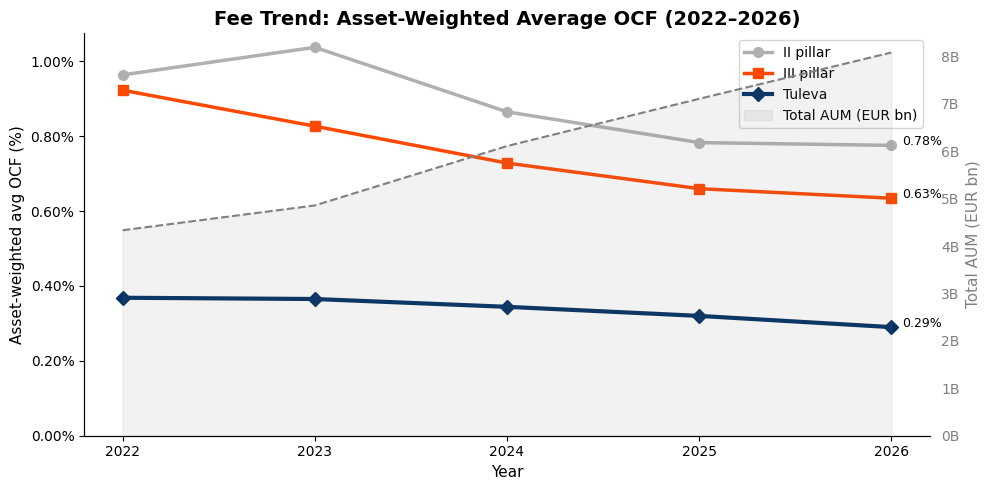

In [7]:
# Fee trend 2022-2026
trends = []
for year in sorted(df['year'].unique()):
    sub = df[df['year'] == year]
    ii = sub[sub['pillar'] == 'II']
    iii = sub[sub['pillar'] == 'III']
    tul = sub[sub['provider'] == 'Tuleva']
    trends.append({
        'year': year,
        'II pillar': weighted_avg(ii['ter'], ii['avg_aum']),
        'III pillar': weighted_avg(iii['ter'], iii['avg_aum']),
        'Tuleva': weighted_avg(tul['ter'], tul['avg_aum']),
    })
trend_df = pd.DataFrame(trends).set_index('year')

fig, ax = plt.subplots(figsize=(10, 5))
styles = {
    'II pillar': {'color': '#B0B0B0', 'linewidth': 2.5, 'marker': 'o'},
    'III pillar': {'color': '#FF4800', 'linewidth': 2.5, 'marker': 's'},
    'Tuleva': {'color': TULEVA_NAVY, 'linewidth': 3, 'marker': 'D'},
}
for col, style in styles.items():
    ax.plot(trend_df.index, trend_df[col], label=col, **style, markersize=7)

ax.set_ylim(0)
ax.set_xlabel('Year')
ax.set_ylabel('Asset-weighted avg OCF (%)')
ax.set_title('Fee Trend: Asset-Weighted Average OCF (2022–2026)', fontweight='bold')
ax.set_xticks(trend_df.index)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.2f}%'))

# End-of-line labels
for col in trend_df.columns:
    last_val = trend_df[col].dropna().iloc[-1]
    last_year = trend_df[col].dropna().index[-1]
    ax.annotate(f'{last_val:.2f}%', (last_year, last_val),
                xytext=(8, 0), textcoords='offset points', fontsize=9)

# Secondary axis: total AUM growth by year
aum_by_year = df.groupby('year')['avg_aum'].sum() / 1e9
ax2 = ax.twinx()
ax2.fill_between(aum_by_year.index, aum_by_year.values,
                 alpha=0.10, color='gray', label='Total AUM (EUR bn)')
ax2.plot(aum_by_year.index, aum_by_year.values,
         color='gray', linewidth=1.5, linestyle='--')
ax2.set_ylabel('Total AUM (EUR bn)', color='gray')
ax2.tick_params(axis='y', labelcolor='gray', length=0, pad=8)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.0f}B'))
ax2.set_ylim(0)

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=10)

plt.tight_layout()
plt.show()

*Overall fees have decreased, but are still way higher than they should be.*

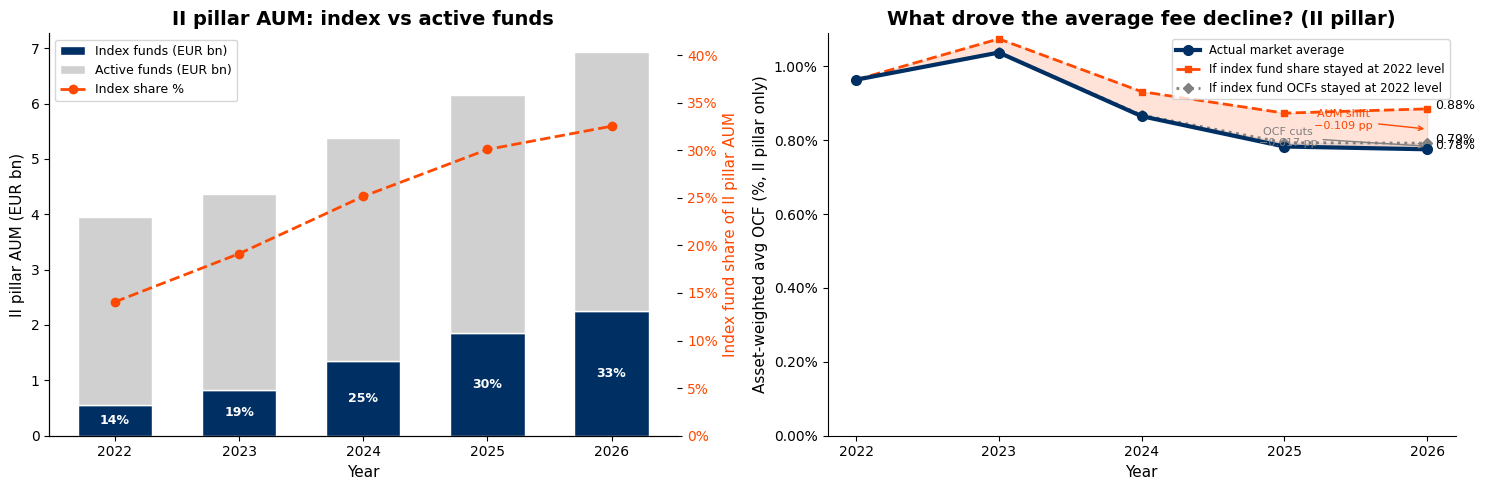

Index fund AUM — II pillar: 0.56bn (14%) in 2022 → 2.25bn (33%) in 2026

Total II pillar average OCF decline 2022→2026: 0.188 pp
  → AUM shift effect (index funds gaining market share):  0.109 pp  (58% of total)
  → OCF reduction effect (index fund fees getting lower):  0.017 pp  (9% of total)


In [8]:
# How loosifondid (index funds) have driven average fee decline — II pillar only
#
# Thesis: The main driver is the growing MARKET SHARE of index funds
# (from ~11% in 2022 to ~33%+ in 2026), not their OCF getting cheaper.

# Work only with II pillar
df_ii = df[df['pillar'] == 'II'].copy()

# --- Part 1: Index fund market share by year (II pillar) ---
share_rows = []
for year in sorted(df_ii['year'].unique()):
    sub = df_ii[df_ii['year'] == year]
    total_aum = sub['avg_aum'].sum()
    index_aum = sub[sub['strategy'] == 'index']['avg_aum'].sum()
    active_aum = total_aum - index_aum
    share_rows.append({
        'year': year,
        'index_share_pct': index_aum / total_aum * 100 if total_aum > 0 else 0,
        'index_aum_bn': index_aum / 1e9,
        'active_aum_bn': active_aum / 1e9,
        'total_aum_bn': total_aum / 1e9,
    })
share_df = pd.DataFrame(share_rows)

# --- Part 2: Counterfactual decomposition (II pillar) ---
sub2022 = df_ii[df_ii['year'] == 2022].copy()
index_2022_ter = sub2022[sub2022['strategy'] == 'index'].set_index('fund')['ter']
total_aum_2022 = sub2022['avg_aum'].sum()
index_aum_share_2022 = sub2022[sub2022['strategy'] == 'index']['avg_aum'].sum() / total_aum_2022

decomp = []
for year in sorted(df_ii['year'].unique()):
    sub = df_ii[df_ii['year'] == year].copy()
    actual = weighted_avg(sub['ter'], sub['avg_aum'])

    # Counterfactual A: AUM share of index funds frozen at 2022 (OCFs change as actual)
    # Gap between this line and actual = effect of index funds gaining market share
    subA = sub.copy()
    total_aum_year = subA['avg_aum'].sum()
    current_index_aum = subA.loc[subA['strategy'] == 'index', 'avg_aum'].sum()
    target_index_aum = total_aum_year * index_aum_share_2022
    if current_index_aum > 0:
        subA.loc[subA['strategy'] == 'index', 'avg_aum'] = (
            subA.loc[subA['strategy'] == 'index', 'avg_aum'] * target_index_aum / current_index_aum
        )
    cf_frozen_share = weighted_avg(subA['ter'], subA['avg_aum'])

    # Counterfactual B: index fund OCFs frozen at 2022 (AUM shifts as actual)
    # Gap between this line and actual = effect of index fund OCFs falling
    subB = sub.copy()
    mapped = subB.loc[subB['strategy'] == 'index', 'fund'].map(index_2022_ter)
    subB.loc[subB['strategy'] == 'index', 'ter'] = mapped
    subB = subB.dropna(subset=['ter'])
    cf_frozen_ocf = weighted_avg(subB['ter'], subB['avg_aum'])

    decomp.append({
        'year': year,
        'actual': actual,
        'cf_frozen_share': cf_frozen_share,
        'cf_frozen_ocf': cf_frozen_ocf,
    })
decomp_df = pd.DataFrame(decomp).set_index('year')

# --- Plot: 2-panel ---
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(15, 5))

# ── Left panel: stacked bar (AUM in EUR bn) + index share % as a line on right axis ──
years = share_df['year'].values
ax_left.bar(years, share_df['index_aum_bn'], color=TULEVA_NAVY, edgecolor='white',
            width=0.6, label='Index funds (EUR bn)')
ax_left.bar(years, share_df['active_aum_bn'], bottom=share_df['index_aum_bn'],
            color='#D0D0D0', edgecolor='white', width=0.6, label='Active funds (EUR bn)')

# Annotate index share % on top of the index portion
for _, row in share_df.iterrows():
    ax_left.text(row['year'], row['index_aum_bn'] / 2,
                 f"{row['index_share_pct']:.0f}%",
                 ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Right y-axis: index share % trend line
ax_l2 = ax_left.twinx()
ax_l2.plot(years, share_df['index_share_pct'], color='#FF4800',
           linewidth=2, marker='o', markersize=6, linestyle='--', label='Index share %')
ax_l2.set_ylabel('Index fund share of II pillar AUM', color='#FF4800')
ax_l2.tick_params(axis='y', labelcolor='#FF4800')
ax_l2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
ax_l2.set_ylim(0, share_df['index_share_pct'].max() * 1.3)

ax_left.set_xlabel('Year')
ax_left.set_ylabel('II pillar AUM (EUR bn)')
ax_left.set_title('II pillar AUM: index vs active funds', fontweight='bold')
ax_left.set_xticks(years)

# Combine legends
h1, l1 = ax_left.get_legend_handles_labels()
h2, l2 = ax_l2.get_legend_handles_labels()
ax_left.legend(h1 + h2, l1 + l2, fontsize=9, loc='upper left')

# ── Right panel: counterfactual lines with shaded gap regions ──
yr_idx = decomp_df.index.values

# Actual line
ax_right.plot(yr_idx, decomp_df['actual'], color=TULEVA_NAVY,
              linewidth=3, marker='o', markersize=7, label='Actual market average', zorder=3)

# "No AUM shift" line + shaded gap
ax_right.plot(yr_idx, decomp_df['cf_frozen_share'], color='#FF4800',
              linewidth=2, marker='s', markersize=5, linestyle='--',
              label='If index fund share stayed at 2022 level')
ax_right.fill_between(yr_idx, decomp_df['actual'], decomp_df['cf_frozen_share'],
                      alpha=0.15, color='#FF4800', label='_nolegend_')

# "No OCF cuts" line + shaded gap
ax_right.plot(yr_idx, decomp_df['cf_frozen_ocf'], color='#808080',
              linewidth=2, marker='D', markersize=5, linestyle=':',
              label='If index fund OCFs stayed at 2022 level')
ax_right.fill_between(yr_idx, decomp_df['actual'], decomp_df['cf_frozen_ocf'],
                      alpha=0.12, color='#808080', label='_nolegend_')

# End-of-line labels
last_yr = yr_idx[-1]
for col, label in [
    ('actual', 'Actual'),
    ('cf_frozen_share', 'No AUM shift'),
    ('cf_frozen_ocf', 'No OCF cuts'),
]:
    val = decomp_df.loc[last_yr, col]
    ax_right.annotate(f'{val:.2f}%', (last_yr, val),
                      xytext=(6, 0), textcoords='offset points', fontsize=9)

# Annotate the gap magnitudes mid-chart
mid_yr = yr_idx[len(yr_idx) // 2]
aum_gap_mid = (decomp_df.loc[mid_yr, 'cf_frozen_share'] + decomp_df.loc[mid_yr, 'actual']) / 2
ocf_gap_mid = (decomp_df.loc[mid_yr, 'cf_frozen_ocf'] + decomp_df.loc[mid_yr, 'actual']) / 2

last_aum_effect = decomp_df.loc[last_yr, 'cf_frozen_share'] - decomp_df.loc[last_yr, 'actual']
last_ocf_effect = decomp_df.loc[last_yr, 'cf_frozen_ocf'] - decomp_df.loc[last_yr, 'actual']

ax_right.annotate(f'AUM shift\n−{last_aum_effect:.3f} pp',
                  xy=(last_yr, (decomp_df.loc[last_yr, 'cf_frozen_share'] + decomp_df.loc[last_yr, 'actual']) / 2),
                  xytext=(-60, 0), textcoords='offset points',
                  fontsize=8, color='#FF4800', ha='center',
                  arrowprops=dict(arrowstyle='->', color='#FF4800', lw=1))
ax_right.annotate(f'OCF cuts\n−{last_ocf_effect:.3f} pp',
                  xy=(last_yr, (decomp_df.loc[last_yr, 'cf_frozen_ocf'] + decomp_df.loc[last_yr, 'actual']) / 2),
                  xytext=(-100, 0), textcoords='offset points',
                  fontsize=8, color='#808080', ha='center',
                  arrowprops=dict(arrowstyle='->', color='#808080', lw=1))

ax_right.set_ylim(0)
ax_right.set_xlabel('Year')
ax_right.set_ylabel('Asset-weighted avg OCF (%, II pillar only)')
ax_right.set_title('What drove the average fee decline? (II pillar)', fontweight='bold')
ax_right.set_xticks(yr_idx)
ax_right.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.2f}%'))
ax_right.legend(fontsize=8.5, loc='upper right')

plt.tight_layout()
plt.show()

# Summary numbers
total_decline = decomp_df['actual'].iloc[0] - decomp_df['actual'].iloc[-1]
aum_effect = decomp_df.loc[last_yr, 'cf_frozen_share'] - decomp_df.loc[last_yr, 'actual']
ocf_effect = decomp_df.loc[last_yr, 'cf_frozen_ocf'] - decomp_df.loc[last_yr, 'actual']

ii_2022 = share_df[share_df['year'] == 2022]['index_share_pct'].values[0]
ii_2022_aum = share_df[share_df['year'] == 2022]['index_aum_bn'].values[0]
ii_late = share_df[share_df['year'] == last_yr]['index_share_pct'].values[0]
ii_late_aum = share_df[share_df['year'] == last_yr]['index_aum_bn'].values[0]

print(f'Index fund AUM — II pillar: {ii_2022_aum:.2f}bn ({ii_2022:.0f}%) in 2022 → '
      f'{ii_late_aum:.2f}bn ({ii_late:.0f}%) in {last_yr}')
print(f'\nTotal II pillar average OCF decline 2022→{last_yr}: {total_decline:.3f} pp')
print(f'  → AUM shift effect (index funds gaining market share):  {aum_effect:.3f} pp  '
      f'({aum_effect/total_decline*100:.0f}% of total)')
print(f'  → OCF reduction effect (index fund fees getting lower):  {ocf_effect:.3f} pp  '
      f'({ocf_effect/total_decline*100:.0f}% of total)')

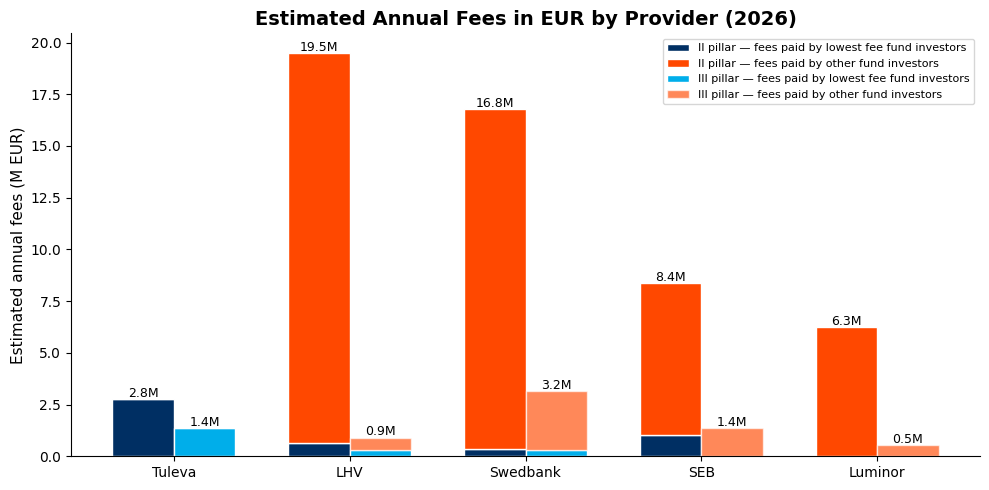

In [9]:
# Total fee revenue estimate by provider (latest year)
latest = df[df['year'] == LATEST_YEAR]

fee_data = []
for provider in PROVIDER_ORDER:
    for pillar in ['II', 'III']:
        sub = latest[(latest['provider'] == provider) & (latest['pillar'] == pillar)]
        if len(sub):
            min_ter = sub['ter'].min()
            low_fee = sub.loc[sub['ter'] == min_ter, 'fee_eur'].sum()
            rest_fee = sub.loc[sub['ter'] != min_ter, 'fee_eur'].sum()
            fee_data.append({
                'provider': provider, 'pillar': pillar,
                'low_fee': low_fee, 'rest_fee': rest_fee,
            })
fee_df = pd.DataFrame(fee_data)
low_fee_pivot = fee_df.pivot(index='provider', columns='pillar', values='low_fee').reindex(PROVIDER_ORDER) / 1e6
rest_fee_pivot = fee_df.pivot(index='provider', columns='pillar', values='rest_fee').reindex(PROVIDER_ORDER) / 1e6

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(PROVIDER_ORDER))
w = 0.35

# II pillar
ax.bar(x - w/2, low_fee_pivot['II'], w, color=TULEVA_NAVY, edgecolor='white',
       label='II pillar — fees paid by lowest fee fund investors')
ax.bar(x - w/2, rest_fee_pivot['II'], w, bottom=low_fee_pivot['II'],
       color='#FF4800', edgecolor='white', label='II pillar — fees paid by other fund investors')

# III pillar
ax.bar(x + w/2, low_fee_pivot['III'], w, color=TULEVA_BLUE, edgecolor='white',
       label='III pillar — fees paid by lowest fee fund investors')
ax.bar(x + w/2, rest_fee_pivot['III'], w, bottom=low_fee_pivot['III'],
       color='#FF4800', edgecolor='white', alpha=0.65, label='III pillar — fees paid by other fund investors')

ax.set_ylim(0)
ax.set_xticks(x)
ax.set_xticklabels(PROVIDER_ORDER)
ax.set_ylabel('Estimated annual fees (M EUR)')
ax.set_title(f'Estimated Annual Fees in EUR by Provider ({LATEST_YEAR})', fontweight='bold')
ax.legend(fontsize=8)

for i, provider in enumerate(PROVIDER_ORDER):
    for pillar, offset in [('II', -w/2), ('III', w/2)]:
        total = low_fee_pivot.loc[provider, pillar] + rest_fee_pivot.loc[provider, pillar]
        if not np.isnan(total) and total > 0:
            ax.text(i + offset, total + 0.1, f'{total:.1f}M', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

*It is not surprising that most investor fees flow to funds that are not the cheapest within each provider's lineup.*

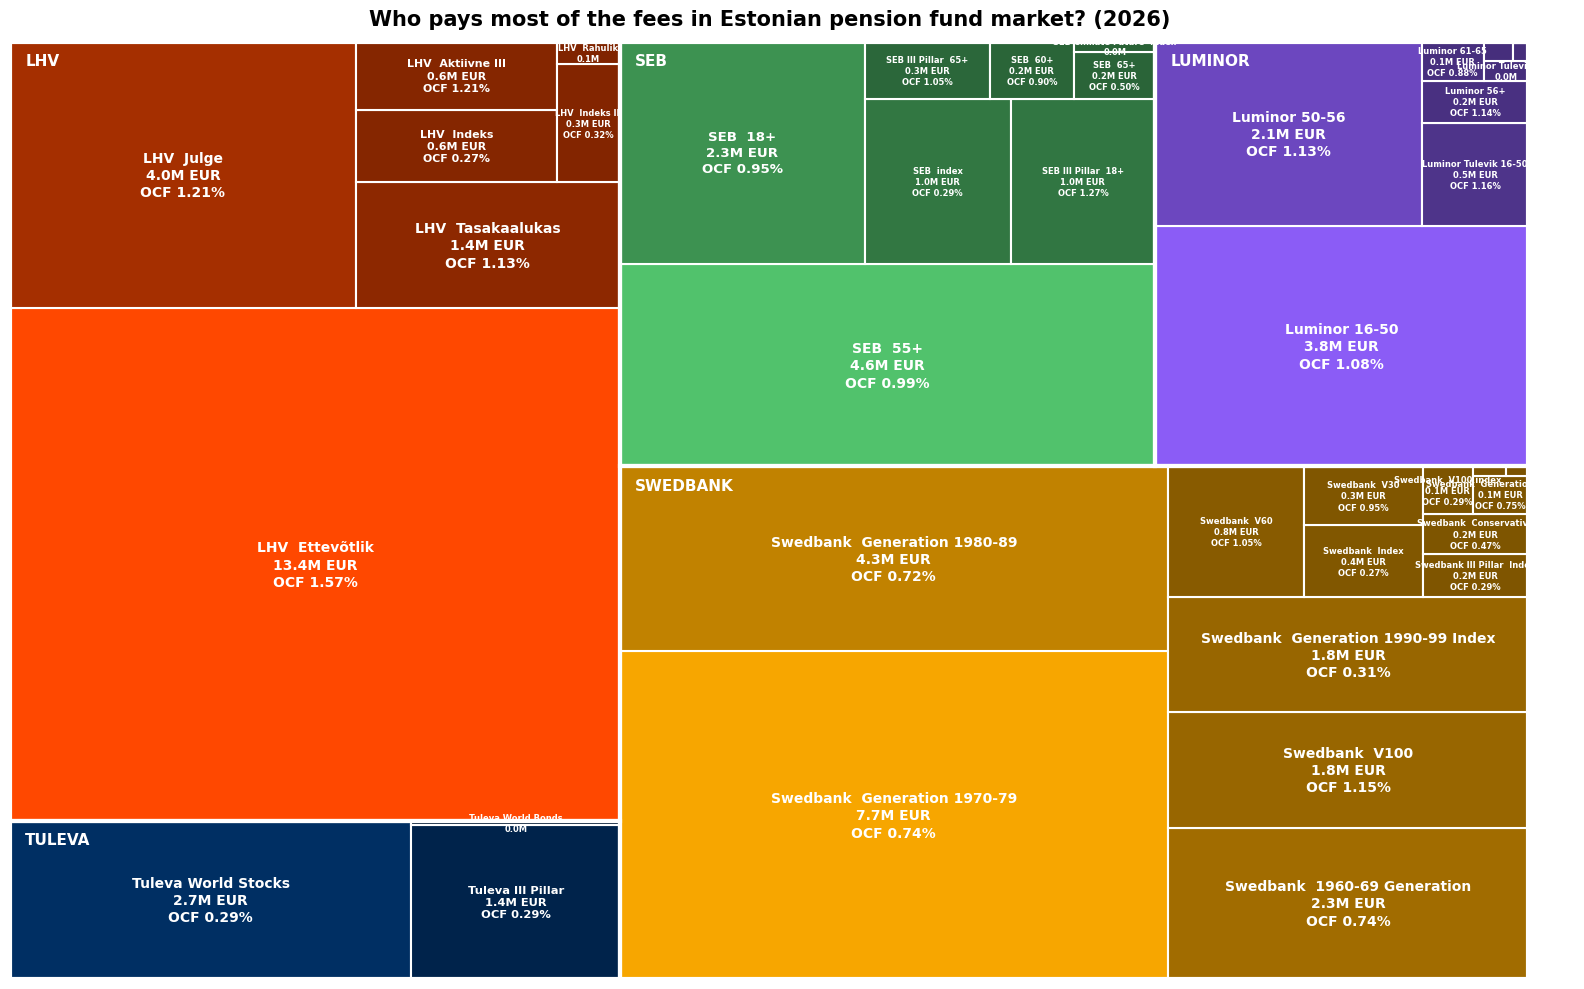

Total estimated annual fees: 61.0M EUR


In [10]:
import squarify
from matplotlib.colors import to_rgba

# Treemap: where pension fund investors pay the most fees
latest = df[df['year'] == LATEST_YEAR].copy()
latest['short_name'] = (latest['fund']
    .str.replace(r'Pensionifond|Pension Fund|Pension fund|pension fund', '', regex=True)
    .str.replace('(limited redemption)', '', regex=False)
    .str.strip())
latest['fee_M'] = latest['fee_eur'] / 1e6
latest = latest.sort_values('fee_eur', ascending=False)

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# First pass: allocate space per provider (like sectors)
provider_fees = latest.groupby('provider')['fee_eur'].sum().reindex(PROVIDER_ORDER).dropna()
provider_rects = squarify.squarify(
    squarify.normalize_sizes(provider_fees.values, 100, 100),
    0, 0, 100, 100)

for provider, prect in zip(provider_fees.index, provider_rects):
    px, py, pw, ph = prect['x'], prect['y'], prect['dx'], prect['dy']
    base_color = PROVIDER_COLORS[provider]

    # Draw provider border
    ax.add_patch(plt.Rectangle((px, py), pw, ph,
                                fill=False, edgecolor='white', linewidth=3, zorder=3))

    # Provider label at top-left
    ax.text(px + 1, py + ph - 1.2, provider.upper(),
            fontsize=11, fontweight='bold', color='white',
            va='top', ha='left', zorder=5)

    # Sub-treemap for funds within this provider
    sub = latest[latest['provider'] == provider].sort_values('fee_eur', ascending=False)
    if len(sub) == 0:
        continue

    # Vary lightness per fund: largest fee = full color, smaller = lighter
    max_fee = sub['fee_eur'].max()
    fund_rects = squarify.squarify(
        squarify.normalize_sizes(sub['fee_eur'].values, pw, ph),
        px, py, pw, ph)

    for (_, row), frect in zip(sub.iterrows(), fund_rects):
        fx, fy, fw, fh = frect['x'], frect['y'], frect['dx'], frect['dy']

        # Darken/lighten based on relative fee size within provider
        ratio = 0.5 + 0.5 * (row['fee_eur'] / max_fee)
        r, g, b, _ = to_rgba(base_color)
        color = (r * ratio, g * ratio, b * ratio, 1.0)

        ax.add_patch(plt.Rectangle((fx, fy), fw, fh,
                                    facecolor=color, edgecolor='white',
                                    linewidth=1.5, zorder=2))

        # Label: fund name + fee amount
        area = fw * fh
        if area > 15:
            label = f"{row['short_name']}\n{row['fee_M']:.1f}M EUR\nOCF {row['ter']:.2f}%"
            fontsize = min(10, max(6, fw * 0.6))
            ax.text(fx + fw/2, fy + fh/2, label,
                    ha='center', va='center', fontsize=fontsize,
                    color='white', fontweight='bold', zorder=4,
                    linespacing=1.3)
        elif area > 5:
            label = f"{row['short_name']}\n{row['fee_M']:.1f}M"
            ax.text(fx + fw/2, fy + fh/2, label,
                    ha='center', va='center', fontsize=6,
                    color='white', fontweight='bold', zorder=4)

ax.set_title(f'Who pays most of the fees in Estonian pension fund market? ({LATEST_YEAR})',
             fontsize=15, fontweight='bold', pad=12)
ax.set_axis_off()

plt.tight_layout()
plt.show()

total_fees = latest['fee_eur'].sum() / 1e6
print(f'Total estimated annual fees: {total_fees:.1f}M EUR')

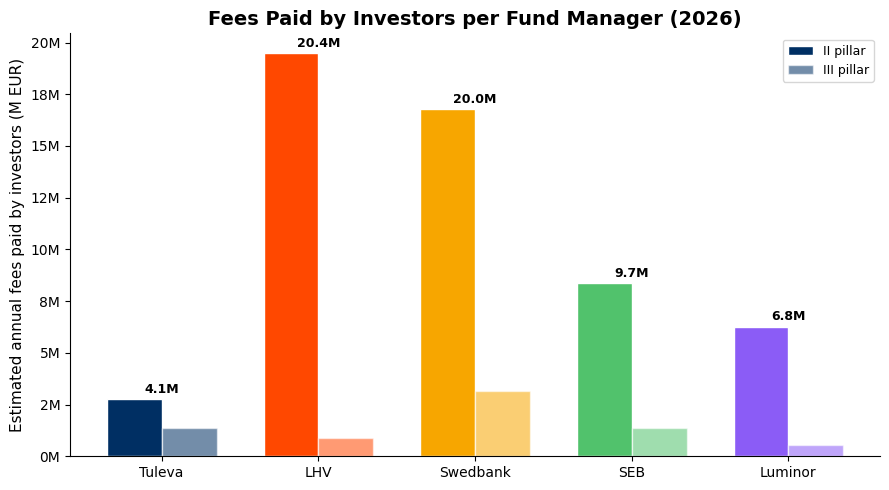

,II pillar (M€),III pillar (M€),Total (M€)
provider,,,
Tuleva,2.8,1.4,4.1
LHV,19.5,0.9,20.4
Swedbank,16.8,3.2,20.0
SEB,8.4,1.4,9.7
Luminor,6.3,0.5,6.8


In [11]:
# Fees paid by investors per fund manager in 2026
latest = df[df['year'] == LATEST_YEAR]

revenue = (latest.groupby(['provider', 'pillar'])['fee_eur']
           .sum().unstack(fill_value=0) / 1e6)
revenue.columns.name = None
for col in ['II', 'III']:
    if col not in revenue.columns:
        revenue[col] = 0.0
revenue['Total'] = revenue['II'] + revenue['III']
revenue = revenue[['II', 'III', 'Total']].reindex(PROVIDER_ORDER).dropna(how='all')
revenue.columns = ['II pillar (M€)', 'III pillar (M€)', 'Total (M€)']

fig, ax = plt.subplots(figsize=(9, 5))
x = np.arange(len(revenue))
w = 0.35
colors = [PROVIDER_COLORS[p] for p in revenue.index]
bars_ii = ax.bar(x - w/2, revenue['II pillar (M€)'], w,
                 color=colors, edgecolor='white', label='II pillar')
bars_iii = ax.bar(x + w/2, revenue['III pillar (M€)'], w,
                  color=colors, alpha=0.55, edgecolor='white', label='III pillar')

for i, (provider, row) in enumerate(revenue.iterrows()):
    total = row['Total (M€)']
    if total > 0:
        ax.text(i, max(row['II pillar (M€)'], row['III pillar (M€)']) + 0.3,
                f"{total:.1f}M", ha='center', fontsize=9, fontweight='bold')

ax.set_ylim(0)
ax.set_xticks(x)
ax.set_xticklabels(revenue.index)
ax.set_ylabel('Estimated annual fees paid by investors (M EUR)')
ax.set_title(f'Fees Paid by Investors per Fund Manager ({LATEST_YEAR})', fontweight='bold')
ax.legend(fontsize=9)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.0f}M'))
plt.tight_layout()
plt.show()

display(revenue.style
        .format('{:.1f}')
        .background_gradient(subset=['Total (M€)'], cmap='Reds')
        .set_caption(f'Estimated annual fees paid by investors, by fund manager ({LATEST_YEAR})'))

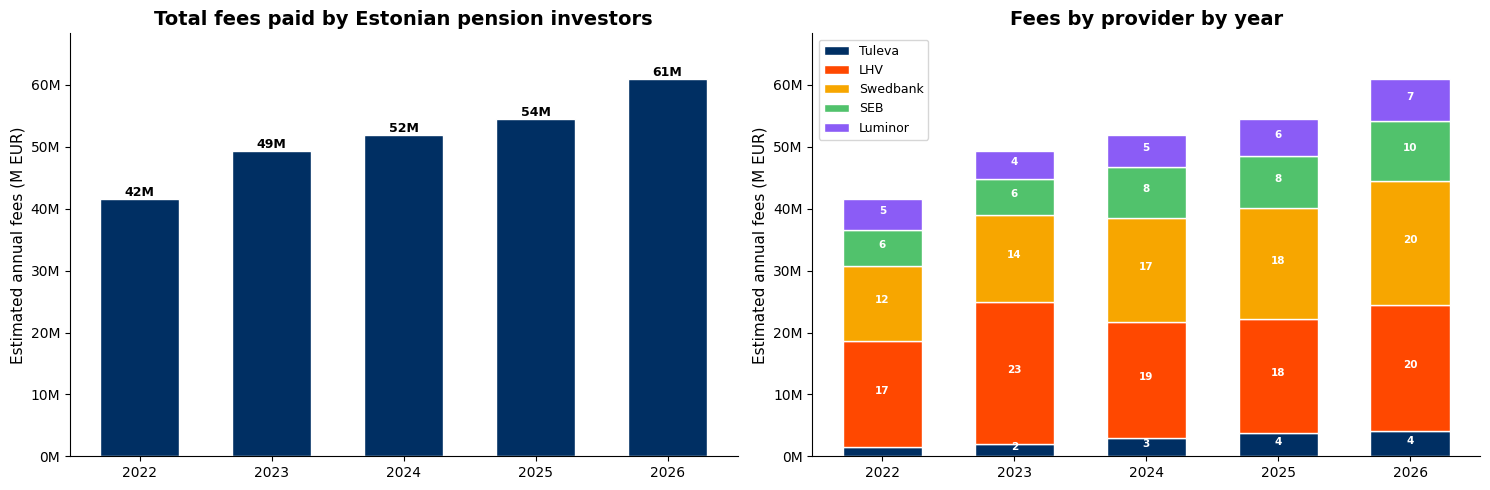

Total estimated fees by year:
  2022: 41.6M EUR
  2023: 49.3M EUR
  2024: 51.8M EUR
  2025: 54.4M EUR
  2026: 61.0M EUR


In [12]:
# Total fees collected per year — are investors paying more or less over time?
fees_by_year = (df.groupby(['year', 'provider'])['fee_eur']
                .sum().unstack(fill_value=0).reindex(columns=PROVIDER_ORDER, fill_value=0) / 1e6)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: market total per year (II + III combined)
totals = fees_by_year.sum(axis=1)
bars = axes[0].bar(totals.index, totals.values, color=TULEVA_NAVY, edgecolor='white', width=0.6)
for yr, val in totals.items():
    axes[0].text(yr, val + 0.5, f'{val:.0f}M', ha='center', fontsize=9, fontweight='bold')
axes[0].set_title('Total fees paid by Estonian pension investors', fontweight='bold')
axes[0].set_ylabel('Estimated annual fees (M EUR)')
axes[0].set_xticks(totals.index)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.0f}M'))
axes[0].set_ylim(0, totals.max() * 1.12)

# Right: stacked by provider per year
x = np.arange(len(fees_by_year))
bottom = np.zeros(len(fees_by_year))
for provider in PROVIDER_ORDER:
    if provider in fees_by_year.columns:
        vals = fees_by_year[provider].values
        axes[1].bar(fees_by_year.index, vals, bottom=bottom,
                    color=PROVIDER_COLORS[provider], edgecolor='white', width=0.6, label=provider)
        # Label each provider's slice if large enough
        for i, (yr, v) in enumerate(zip(fees_by_year.index, vals)):
            if v > 2:
                axes[1].text(yr, bottom[i] + v / 2, f'{v:.0f}', ha='center',
                             fontsize=7.5, color='white', fontweight='bold')
        bottom += vals

axes[1].set_title('Fees by provider by year', fontweight='bold')
axes[1].set_ylabel('Estimated annual fees (M EUR)')
axes[1].set_xticks(fees_by_year.index)
axes[1].legend(fontsize=9, loc='upper left')
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.0f}M'))
axes[1].set_ylim(0, fees_by_year.sum(axis=1).max() * 1.12)

plt.tight_layout()
plt.show()

print('Total estimated fees by year:')
for yr, val in totals.items():
    print(f'  {yr}: {val:.1f}M EUR')

II pillar management fees: 24 funds
                                          fund  mgmt_fee
                   LHV Pensionifond Ettevõtlik    0.6000
                       LHV Pensionifond Indeks    0.1800
                        LHV Pensionifond Julge    0.6000
                      LHV Pensionifond Rahulik    0.5040
                 LHV Pensionifond Tasakaalukas    0.6000
                    Luminor 16-50 pension fund    0.8500
                    Luminor 50-56 pension fund    0.8500
                      Luminor 56+ pension fund    0.8500
                    Luminor 61-65 pension fund    0.7000
                    Luminor Index Pension fund    0.2200
                          SEB pension fund 18+    0.6506
                          SEB pension fund 55+    0.6506
                          SEB pension fund 60+    0.6506
                          SEB pension fund 65+    0.3900
                        SEB pension fund index    0.2300
      Swedbank Pension Fund 1960-69 Generation    0.


III pillar management fees: 17 funds (reference only)

Matched 41 funds with both AUM and management fee data

--- §65'1 Qualifying AUM Diagnostic (II pillar only) ---
  Tuleva      Tuleva World Stocks Pension Fund                      fee=0.215%  AUM=937M€
  Tuleva      Tuleva World Bonds Pension Fund                       fee=0.173%  AUM=12M€
  LHV         LHV Pensionifond Ettevõtlik                           fee=0.600%  AUM=854M€ ← qualifies
  LHV         LHV Pensionifond Julge                                fee=0.600%  AUM=327M€ ← qualifies
  LHV         LHV Pensionifond Tasakaalukas                         fee=0.600%  AUM=126M€ ← qualifies
  LHV         LHV Pensionifond Rahulik                              fee=0.504%  AUM=12M€ ← qualifies
  LHV         LHV Pensionifond Indeks                               fee=0.180%  AUM=230M€
  Swedbank    Swedbank Pension Fund 1960-69 Generation              fee=0.530%  AUM=317M€ ← qualifies
  Swedbank    Swedbank Pension Fund Generation 1970-7

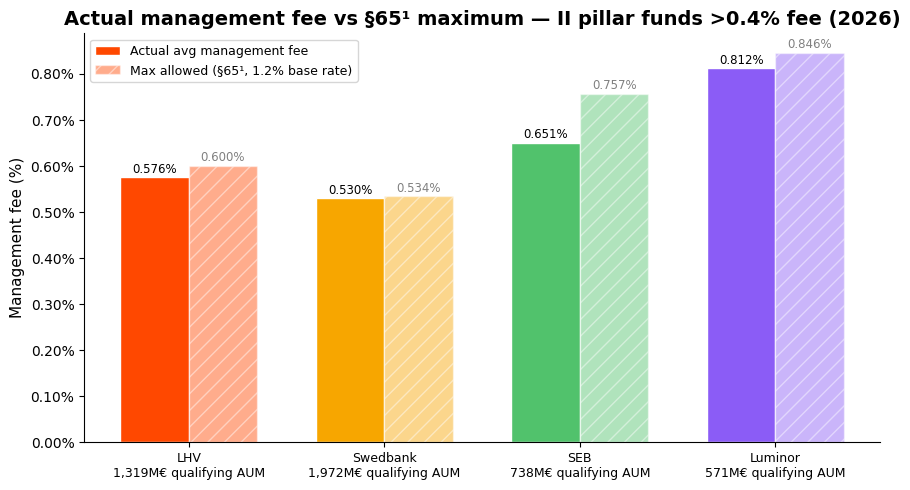

Provider,Fund,Actual management fee (%),Max allowed §65¹ (%),Excess above cap (pp),Provider qualifying AUM (M€)
LHV,LHV Pensionifond Ettevõtlik,0.600,0.600,+0.000,"1,319"
LHV,LHV Pensionifond Julge,0.600,0.600,+0.000,"1,319"
LHV,LHV Pensionifond Rahulik,0.504,0.600,-0.096,"1,319"
LHV,LHV Pensionifond Tasakaalukas,0.600,0.600,+0.000,"1,319"
Swedbank,Swedbank Pension Fund 1960-69 Generation,0.530,0.534,-0.004,"1,972"
Swedbank,Swedbank Pension Fund Generation 1970-79,0.530,0.534,-0.004,"1,972"
Swedbank,Swedbank Pension Fund Generation 1980-89,0.530,0.534,-0.004,"1,972"
Swedbank,Swedbank Pension Fund Generation 2000-09,0.530,0.534,-0.004,"1,972"
SEB,SEB pension fund 18+,0.651,0.757,-0.107,738
SEB,SEB pension fund 55+,0.651,0.757,-0.107,738



3 of 15 qualifying funds have a management fee above the §65¹ cap.


In [13]:
# §65'1 of investeerimisfondide seadus — maximum allowed management fee vs actual
#
# How §65'1 works:
#   1. Start at 1.2% (statutory maximum starting rate)
#   2. For every 100M EUR block of qualifying AUM, the marginal rate drops by 15%
#      (floored at 0.4%)
#   3. Sum all block fees, divide by total assets → blended effective maximum rate
#
# "Qualifying AUM" = II pillar fund assets managed by the FMC where management fee > 0.4%
# (II pillar only; applies to all fund types — active and index alike)
#
# Example results (base rate 1.2%):
#   50M EUR    → 1.200%
#   576M EUR   → ~0.841%  (Luminor-sized)
#   1,346M EUR → ~0.598%  (LHV-sized)
#   2,001M EUR → ~0.535%  (Swedbank-sized)

BASE_FEE_RATE = 0.012  # 1.2% statutory starting rate


def calc_max_fee_65_1(total_assets_eur,
                      base_fee_rate=BASE_FEE_RATE,
                      min_fee_floor=0.004,
                      block_size=100_000_000,
                      reduction_factor=0.85):
    """
    Compute §65'1 blended effective maximum fee rate.
    For each 100M EUR block: fee = block * current_rate, then rate *= 0.85 (min 0.4%).
    Returns total_fee / total_assets_eur.
    """
    remaining = total_assets_eur
    current_rate = base_fee_rate
    total_fee = 0.0
    while remaining > 0:
        chunk = min(remaining, block_size)
        total_fee += chunk * current_rate
        remaining -= chunk
        current_rate = max(current_rate * reduction_factor, min_fee_floor)
    return total_fee / total_assets_eur


def scrape_mgmt_fees(url):
    """Scrape management fee table from pensionikeskus.ee (works for both EN and ET pages)."""
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, 'html.parser')
    table = soup.find('table')
    rows = table.find_all('tr')
    headers = [th.get_text(strip=True) for th in rows[0].find_all(['th', 'td'])]
    data = []
    for row in rows[1:]:
        cells = [td.get_text(strip=True) for td in row.find_all(['td', 'th'])]
        if cells and cells[0]:
            data.append(cells)
    df_raw = pd.DataFrame(data, columns=headers)
    df_raw = df_raw.rename(columns={headers[0]: 'fund'})
    df_raw['fund'] = df_raw['fund'].str.strip()
    mgmt_col = [c for c in df_raw.columns
                if any(kw in c for kw in ('Management fee', 'Valitsemistasu', 'alitsemis'))]
    if not mgmt_col:
        raise ValueError(f'No management fee column found. Columns: {df_raw.columns.tolist()}')
    df_raw['mgmt_fee'] = (df_raw[mgmt_col[0]]
                          .str.replace('%', '').str.replace(',', '.').str.strip())
    df_raw['mgmt_fee'] = pd.to_numeric(df_raw['mgmt_fee'], errors='coerce')
    return df_raw[['fund', 'mgmt_fee']].dropna(subset=['mgmt_fee'])


# ── II pillar: English page → English fund names match AUM data directly ──
df_ii_mgmt = scrape_mgmt_fees(
    'https://www.pensionikeskus.ee/en/ii-pillar/funds-fees/fund-fees-comparison/')
df_ii_mgmt['pillar'] = 'II'
print(f'II pillar management fees: {len(df_ii_mgmt)} funds')
print(df_ii_mgmt[['fund', 'mgmt_fee']].to_string(index=False))

# ── III pillar: Estonian page → map to English names ──
df_iii_mgmt_raw = scrape_mgmt_fees(
    'https://www.pensionikeskus.ee/iii-sammas/vabatahtlikud-fondid/fonditasude-vordlus/')
df_iii_mgmt_raw['fund'] = df_iii_mgmt_raw['fund'].map(III_NAME_MAP).fillna(df_iii_mgmt_raw['fund'])
df_iii_mgmt_raw['pillar'] = 'III'
print(f'\nIII pillar management fees: {len(df_iii_mgmt_raw)} funds (reference only)')

mgmt_fees = pd.concat([df_ii_mgmt, df_iii_mgmt_raw], ignore_index=True)

# ── Join with latest AUM data ──
latest = df[df['year'] == LATEST_YEAR][['fund', 'pillar', 'avg_aum', 'provider']].copy()
merged = latest.merge(mgmt_fees, on=['fund', 'pillar'], how='inner')
merged['provider'] = merged['fund'].apply(parse_provider)
print(f'\nMatched {len(merged)} funds with both AUM and management fee data')
unmatched = set(mgmt_fees['fund']) - set(merged['fund'])
if unmatched:
    print(f'Unmatched (no AUM): {unmatched}')

# ── §65'1 uses II pillar only ──
merged_ii = merged[merged['pillar'] == 'II'].copy()

# ── Diagnostic: show all II pillar funds with fees and AUM ──
print('\n--- §65\'1 Qualifying AUM Diagnostic (II pillar only) ---')
diag_rows = []
for provider in PROVIDER_ORDER:
    prov = merged_ii[merged_ii['provider'] == provider]
    total_ii = prov['avg_aum'].sum() / 1e6
    qualifying = prov[prov['mgmt_fee'] > 0.4]
    q_aum = qualifying['avg_aum'].sum() / 1e6
    max_r = calc_max_fee_65_1(q_aum * 1e6, BASE_FEE_RATE) * 100 if q_aum > 0 else None
    diag_rows.append({
        'Provider': provider,
        'Total II pillar AUM (M€)': round(total_ii),
        'Qualifying AUM >0.4% (M€)': round(q_aum),
        '§65¹ max rate': f'{max_r:.3f}%' if max_r else 'n/a (all ≤0.4%)',
    })
    for _, r in prov.sort_values('mgmt_fee', ascending=False).iterrows():
        flag = ' ← qualifies' if r['mgmt_fee'] > 0.4 else ''
        print(f'  {provider:10s}  {r["fund"][:52]:52s}  fee={r["mgmt_fee"]:.3f}%  AUM={r["avg_aum"]/1e6:,.0f}M€{flag}')

print()
print(pd.DataFrame(diag_rows).set_index('Provider').to_string())

# ── Apply §65'1 per provider ──
rows = []
for provider in PROVIDER_ORDER:
    prov_sub = merged_ii[merged_ii['provider'] == provider]
    qualifying_sub = prov_sub[prov_sub['mgmt_fee'] > 0.4].copy()
    if len(qualifying_sub) == 0:
        continue
    total_assets = qualifying_sub['avg_aum'].sum()
    max_rate = calc_max_fee_65_1(total_assets, BASE_FEE_RATE) * 100
    for _, fund_row in qualifying_sub.iterrows():
        rows.append({
            'Provider': provider,
            'Fund': fund_row['fund'],
            'Actual management fee (%)': round(fund_row['mgmt_fee'], 3),
            'Max allowed §65¹ (%)': round(max_rate, 3),
            'Excess above cap (pp)': round(fund_row['mgmt_fee'] - max_rate, 3),
            'Provider qualifying AUM (M€)': round(total_assets / 1e6, 0),
        })

cap_df = pd.DataFrame(rows)

# ── Summary bar chart ──
summary_65 = cap_df.groupby('Provider').agg(
    actual_avg=('Actual management fee (%)', 'mean'),
    max_cap=('Max allowed §65¹ (%)', 'first'),
    total_aum=('Provider qualifying AUM (M€)', 'first'),
).reindex(PROVIDER_ORDER).dropna()

fig, ax = plt.subplots(figsize=(9, 5))
x = np.arange(len(summary_65))
w = 0.35
colors = [PROVIDER_COLORS[p] for p in summary_65.index]
ax.bar(x - w/2, summary_65['actual_avg'], w, color=colors,
       label='Actual avg management fee', edgecolor='white')
ax.bar(x + w/2, summary_65['max_cap'], w, color=colors, alpha=0.45,
       label='Max allowed (§65¹, 1.2% base rate)', edgecolor='white', hatch='//')

for i, (provider, row) in enumerate(summary_65.iterrows()):
    ax.text(i - w/2, row['actual_avg'] + 0.01, f"{row['actual_avg']:.3f}%",
            ha='center', fontsize=8.5)
    ax.text(i + w/2, row['max_cap'] + 0.01, f"{row['max_cap']:.3f}%",
            ha='center', fontsize=8.5, color='gray')

ax.set_xticks(x)
# Qualifying AUM shown as second line of x-tick label
ax.set_xticklabels(
    [f'{p}\n{summary_65.loc[p, "total_aum"]:,.0f}M€ qualifying AUM' for p in summary_65.index],
    fontsize=9,
)
ax.set_ylabel('Management fee (%)')
ax.set_title(f'Actual management fee vs §65¹ maximum — II pillar funds >0.4% fee ({LATEST_YEAR})',
             fontweight='bold')
ax.legend(fontsize=9)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.2f}%'))
ax.set_ylim(0)
plt.tight_layout()
plt.show()

# ── Detailed table ──
def highlight_excess(val):
    if isinstance(val, (int, float)) and val > 0:
        return 'background-color: #ffcccc; font-weight: bold'
    return ''

display(cap_df.style
        .map(highlight_excess, subset=['Excess above cap (pp)'])
        .format({
            'Actual management fee (%)': '{:.3f}',
            'Max allowed §65¹ (%)': '{:.3f}',
            'Excess above cap (pp)': '{:+.3f}',
            'Provider qualifying AUM (M€)': '{:,.0f}',
        })
        .set_caption(
            f'§65¹ Maximum vs Actual Management Fee — II pillar funds with mgmt fee >0.4% ({LATEST_YEAR})')
        .hide(axis='index'))

n_excess = (cap_df['Excess above cap (pp)'] > 0).sum()
print(f'\n{n_excess} of {len(cap_df)} qualifying funds have a management fee above the §65¹ cap.')